In [50]:
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from models.FITS import FITS
from torch import optim
from torch import nn
import torch

In [51]:
%config InlineBackend.figure_format='retina'

In [52]:
# model
seq_len = 720
pred_len = 360
n_epochs = 10
batch_size = 64
n_features = 1

# data
n_samples = int(1e4)
seasonal_period = 900

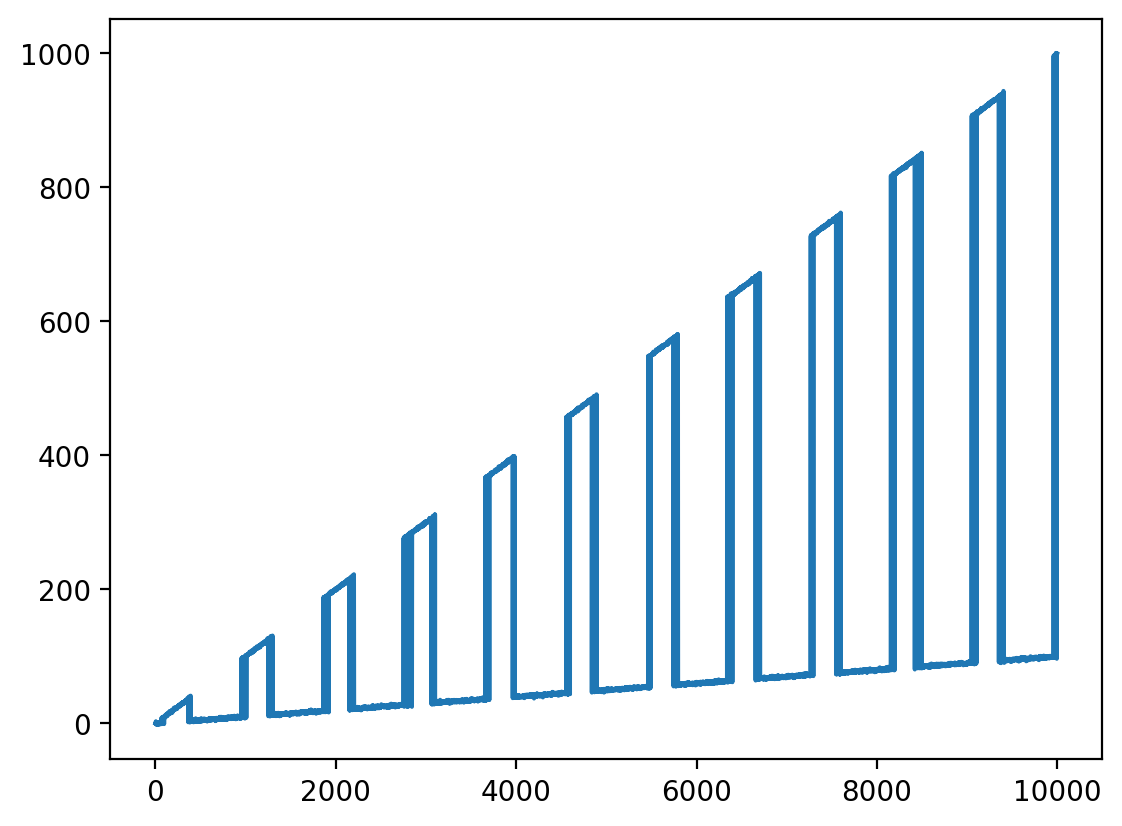

In [53]:
t = np.arange(n_samples)
seasonal_effect = 10 * np.sin(2 * np.pi * t / seasonal_period)
noise = np.random.normal(0, 1, n_samples)
data_seasonal = seasonal_effect + noise

threshold_effect = np.piecewise(
    t, [data_seasonal < 5, data_seasonal >= 5], [lambda t: t * 0.01, lambda t: t * 0.1]
)
data_threshold_effect = threshold_effect + noise

plt.plot(t, data_threshold_effect)
plt.show()

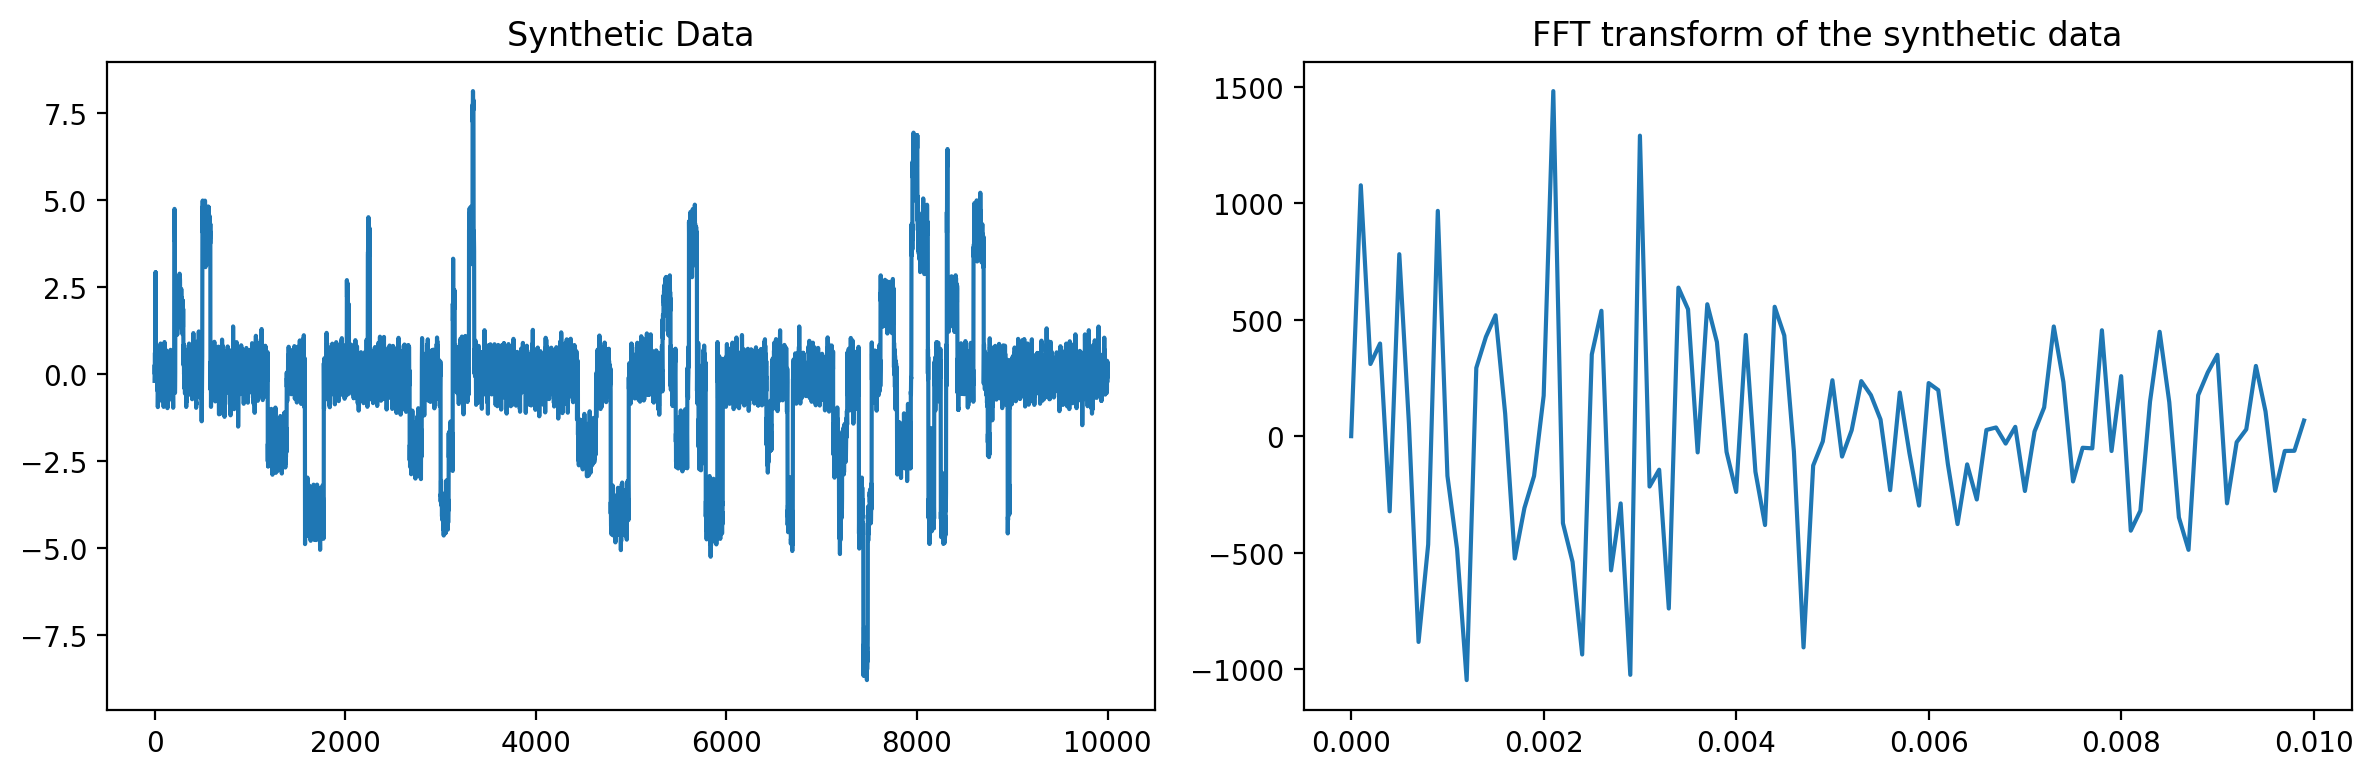

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from synthgen import SyntheticDatasetGenerator

# Generate the synthetic dataset
n_samples = 10000
ds = SyntheticDatasetGenerator(length=n_samples)
ds.add_sin_wave(amplitude=0.3, frequency=200)
ds.add_sin_wave(amplitude=0.3, frequency=500)
ds.add_noise(mean=0, std=0.3)
ds.add_random_signal_with_precursor(
    precursor_amplitude=2,
    signal_amplitude=4,
    max_precursor_length=200,
    min_delay=150,
    max_delay=200,
    num_signals=int(n_samples / 500),
)

# Normalize the data
y = ds.data
y = (y - y.mean()) / y.std()

# Compute the FFT
t = np.arange(len(y))
sp = np.fft.fft(y)
freq = np.fft.fftfreq(t.shape[-1])

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the synthetic data
axes[0].set_title("Synthetic Data")
axes[0].plot(ds.data[:10000])

# Plot the FFT transform
axes[1].set_title("FFT transform of the synthetic data")
axes[1].plot(freq[:100], sp.real[:100])

plt.tight_layout()
plt.show()


In [70]:
x_lims = (-5, 400)

cutoff_frequencies = [5, 10, 50, 359]
subset_length = 1000
data_subset = y[:subset_length]

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def apply_lowpass_filter(signal, cutoff_frequency):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()
    
    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)
    
    # 2) Perform real fast Fourier transform on the input tensor
    low_specx = np.fft.rfft(x)

    # 3) Perform a low pass filter to remove high frequency noise, which contributes little to the overall signal
    low_specx[cutoff_frequency:] = 0
    
    # 4) Perform inverse real fast Fourier transform on the output tensor
    low_x = np.fft.irfft(low_specx, n=len(x))
    
    # 5) Reverse Normalization
    x = (low_x) * np.sqrt(x_var) + x_mean
    return x

def step12(signal):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()
    
    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)
    
    # 2) Perform real fast Fourier transform on the input tensor
    low_specx = np.fft.rfft(x)
    
    return low_specx

def step123(signal, cutoff_frequency):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()
    
    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)
    
    # 2) Perform real fast Fourier transform on the input tensor
    low_specx = np.fft.rfft(x)

    # 3) Perform a low pass filter to remove high frequency noise, which contributes little to the overall signal
    low_specx[cutoff_frequency:] = 0
    
    return low_specx


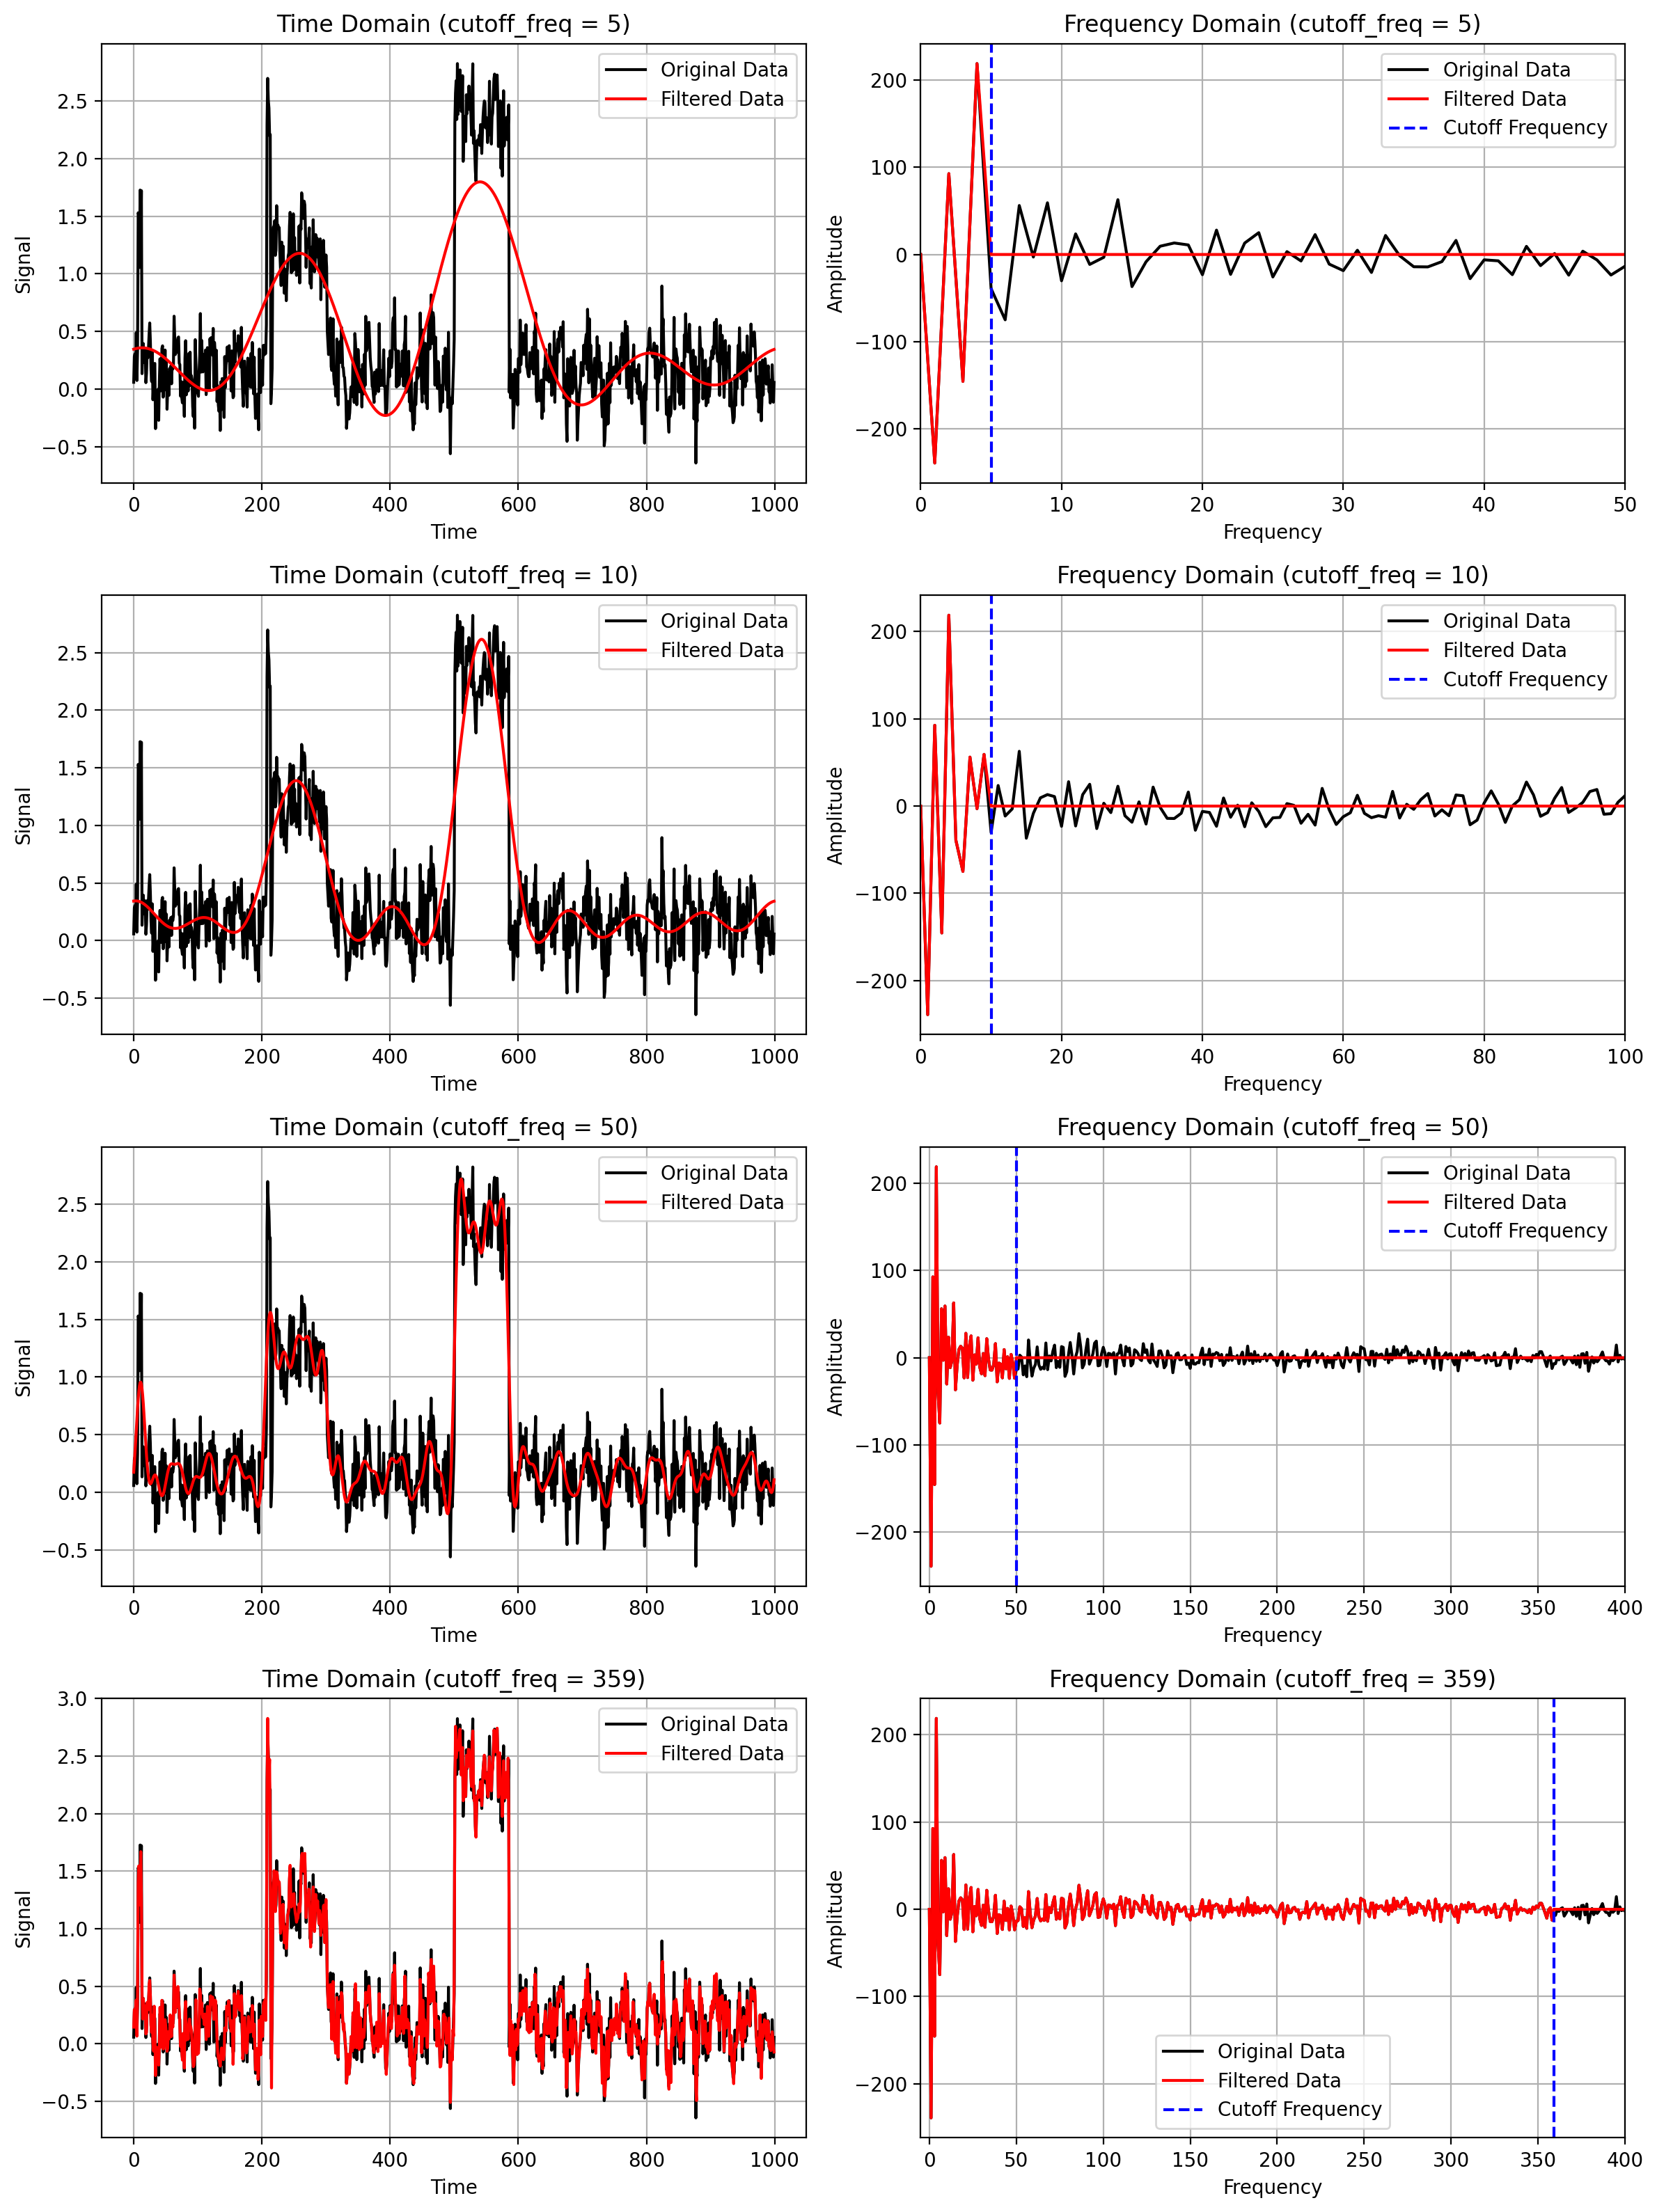

In [72]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Plot for the first script
for i, cutoff_freq in enumerate(cutoff_frequencies):
    filtered_data = apply_lowpass_filter(data_subset, cutoff_freq)

    row = i
    col = 0

    axs[row, col].plot(data_subset, color='black', label='Original Data')
    axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Signal')
    axs[row, col].set_title(f'Time Domain (cutoff_freq = {cutoff_freq})')
    axs[row, col].legend()
    axs[row, col].grid(True)

# Plot for the second script
for i, cutoff_freq in enumerate(cutoff_frequencies):
    original_data = step12(data_subset)
    filtered_data = step123(data_subset, cutoff_freq)

    row = i
    col = 1

    axs[row, col].plot(original_data, color='black', label='Original Data')
    axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
    axs[row, col].axvline(x=cutoff_freq, color='blue', linestyle='--', label='Cutoff Frequency')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('Amplitude')
    axs[row, col].set_title(f'Frequency Domain (cutoff_freq = {cutoff_freq})')
    axs[row, col].legend()
    axs[row, col].grid(True)
    if cutoff_freq == cutoff_frequencies[0]:
        axs[row, col].set_xlim(0, 50)
    elif cutoff_freq == cutoff_frequencies[1]:
        axs[row, col].set_xlim(0, 100)
    else:
        axs[row, col].set_xlim(x_lims)

plt.tight_layout()
plt.show()

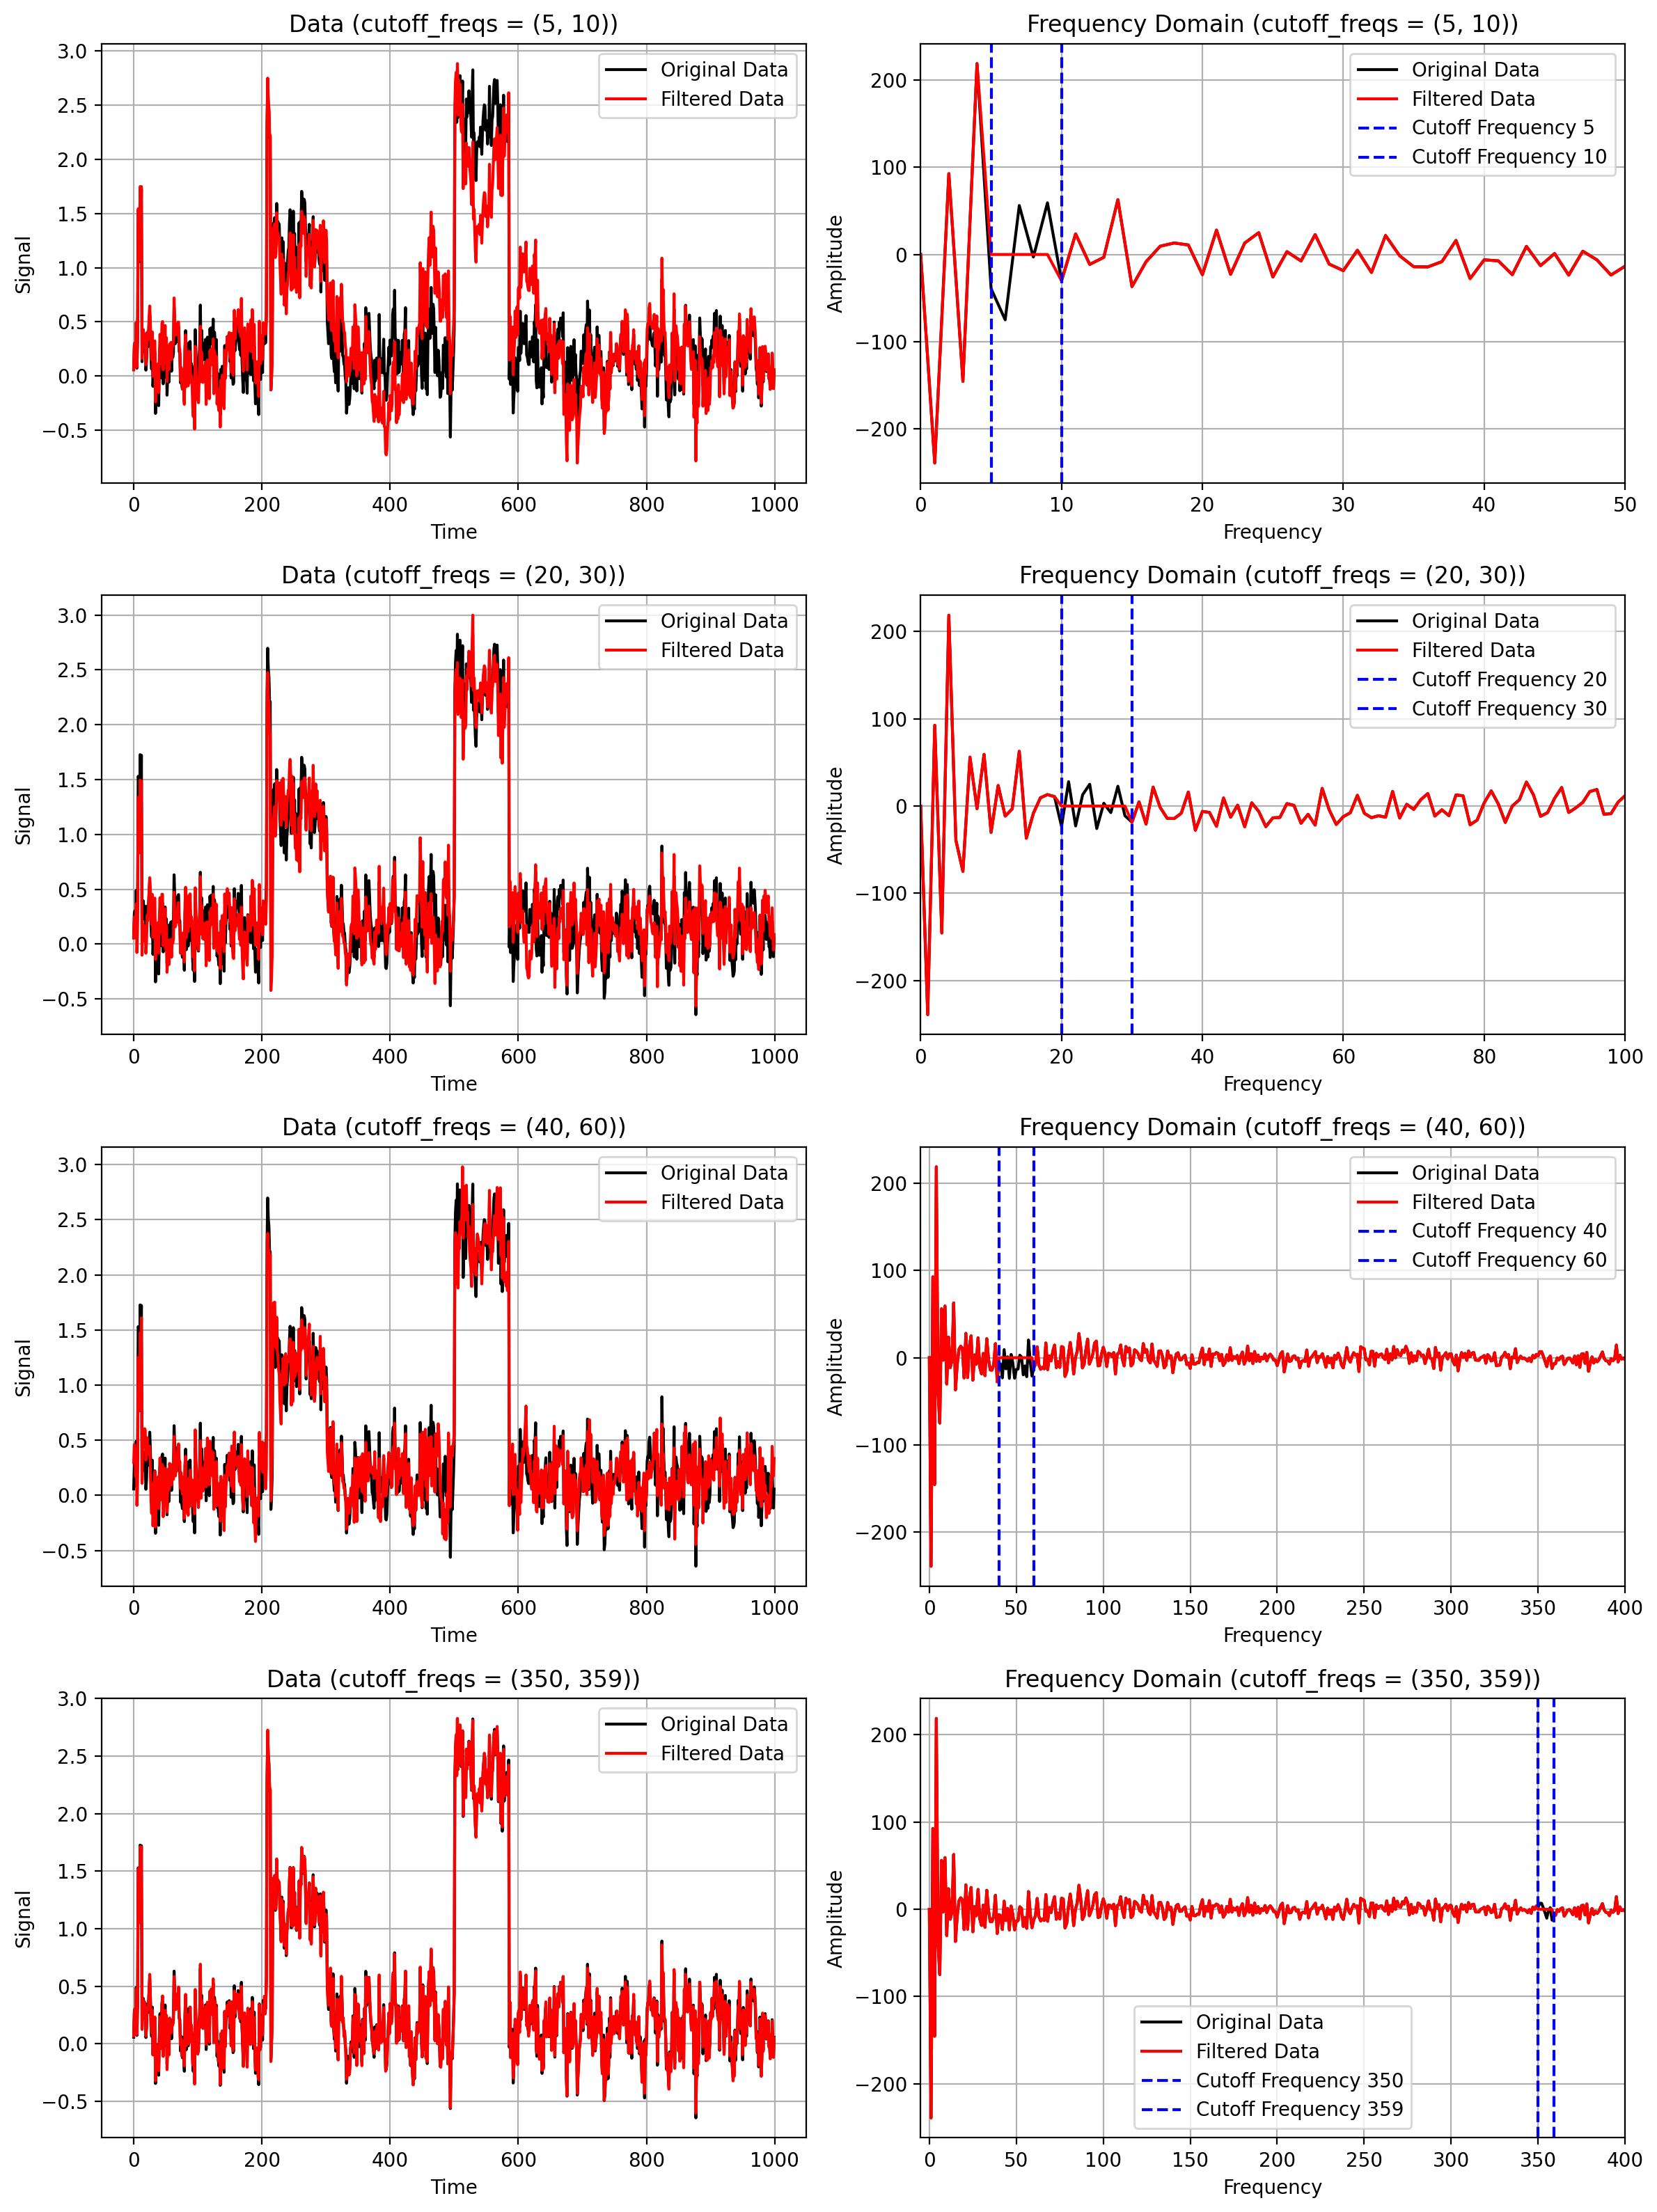

In [68]:
x_lims = (-5, 400)

cutoff_frequencies = [(5, 10), (20, 30), (40, 60), (350, 359)]
subset_length = 1000
data_subset = y[:subset_length]

import numpy as np
import matplotlib.pyplot as plt

def apply_bandstop_filter(signal, cutoff_frequencies):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()
    
    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)
    
    # 2) Perform real fast Fourier transform on the input tensor
    specx = np.fft.rfft(x)

    # 3) Perform a band stop filter to remove specific frequency noise
    for cutoff_freq in cutoff_frequencies:
        specx[cutoff_freq[0]:cutoff_freq[1]] = 0
    
    # 4) Perform inverse real fast Fourier transform on the output tensor
    filtered_x = np.fft.irfft(specx, n=len(x))
    
    # 5) Reverse Normalization
    x = (filtered_x) * np.sqrt(x_var) + x_mean
    return x

def step12(signal):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()
    
    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)
    
    # 2) Perform real fast Fourier transform on the input tensor
    specx = np.fft.rfft(x)
    
    return specx

def step123(signal, cutoff_frequencies):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()
    
    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)
    
    # 2) Perform real fast Fourier transform on the input tensor
    specx = np.fft.rfft(x)

    # 3) Perform a band stop filter to remove specific frequency noise
    for cutoff_freq in cutoff_frequencies:
        specx[cutoff_freq[0]:cutoff_freq[1]] = 0
    
    return specx

fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Plot for the first script
for i, cutoff_freqs in enumerate(cutoff_frequencies):
    filtered_data = apply_bandstop_filter(data_subset, [cutoff_freqs])

    row = i
    col = 0

    axs[row, col].plot(data_subset, color='black', label='Original Data')
    axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Signal')
    axs[row, col].set_title(f'Data (cutoff_freqs = {cutoff_freqs})')
    axs[row, col].legend()
    axs[row, col].grid(True)

# Plot for the second script
for i, cutoff_freqs in enumerate(cutoff_frequencies):
    original_data = step12(data_subset)
    filtered_data = step123(data_subset, [cutoff_freqs])

    row = i
    col = 1

    axs[row, col].plot(original_data, color='black', label='Original Data')
    axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
    for cutoff_freq in cutoff_freqs:
        axs[row, col].axvline(x=cutoff_freq, color='blue', linestyle='--', label=f'Cutoff Frequency {cutoff_freq}')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('Amplitude')
    axs[row, col].set_title(f'Frequency Domain (cutoff_freqs = {cutoff_freqs})')
    axs[row, col].legend()
    axs[row, col].grid(True)
    if cutoff_freqs == cutoff_frequencies[0]:
        axs[row, col].set_xlim(0, 50)
    elif cutoff_freqs == cutoff_frequencies[1]:
        axs[row, col].set_xlim(0, 100)
    else:
        axs[row, col].set_xlim(x_lims)

plt.tight_layout()
plt.show()

In [58]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# for i, cutoff_freq in enumerate(cutoff_frequencies):
#     filtered_data = apply_lowpass_filter(data_subset, cutoff_freq)

#     row = i // 2
#     col = i % 2

#     axs[row, col].plot(data_subset, color='black', label='Original Data')
#     axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel('Amplitude')
#     axs[row, col].set_title(f'Cutoff Frequency = {cutoff_freq}')
#     axs[row, col].legend()
#     axs[row, col].grid(True)

# # plt.tight_layout()
# plt.show()

In [59]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# for i, cutoff_freq in enumerate(cutoff_frequencies):
#     original_data = step12(data_subset)
#     filtered_data = step123(data_subset, cutoff_freq)

#     row = i // 2
#     col = i % 2

#     axs[row, col].plot(original_data, color='black', label='Original Data')
#     axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel('Amplitude')
#     axs[row, col].set_title(f'Cutoff Frequency = {cutoff_freq}')
#     axs[row, col].legend()
#     axs[row, col].grid(True)
#     axs[row, col].set_xlim(x_lims)
    

# # plt.tight_layout()
# plt.show()

In [60]:
# import numpy as np
# import matplotlib.pyplot as plt

# def apply_lowpass_filter(signal, cutoff_frequency):
#     # Create a local copy of the input signal to avoid in-place modification
#     x = signal.copy()
    
#     # 1) Normalization of the input tensor:
#     x_mean = np.mean(x)
#     x -= x_mean
#     x_var = np.var(x) + 1e-5
#     x /= np.sqrt(x_var)
    
#     # 2) Perform real fast Fourier transform on the input tensor
#     low_specx = np.fft.rfft(x)

#     # 3) Perform a low pass filter to remove high frequency noise, which contributes little to the overall signal
#     low_specx[cutoff_frequency:] = 0
    
#     # 4) Perform inverse real fast Fourier transform on the output tensor
#     low_x = np.fft.irfft(low_specx, n=len(x))
    
#     # 5) Reverse Normalization
#     x = (low_x) * np.sqrt(x_var) + x_mean
#     return x

# def step12(signal):
#     # Create a local copy of the input signal to avoid in-place modification
#     x = signal.copy()
    
#     # 1) Normalization of the input tensor:
#     x_mean = np.mean(x)
#     x -= x_mean
#     x_var = np.var(x) + 1e-5
#     x /= np.sqrt(x_var)
    
#     # 2) Perform real fast Fourier transform on the input tensor
#     low_specx = np.fft.rfft(x)
    
#     return low_specx

# def step123(signal, cutoff_frequency):
#     # Create a local copy of the input signal to avoid in-place modification
#     x = signal.copy()
    
#     # 1) Normalization of the input tensor:
#     x_mean = np.mean(x)
#     x -= x_mean
#     x_var = np.var(x) + 1e-5
#     x /= np.sqrt(x_var)
    
#     # 2) Perform real fast Fourier transform on the input tensor
#     low_specx = np.fft.rfft(x)

#     # 3) Perform a low pass filter to remove high frequency noise, which contributes little to the overall signal
#     low_specx[cutoff_frequency:] = 0
    
#     return low_specx

# # Use a smaller subset for testing
# subset_length = 1000

# cutoff_frequencies = [5, 10, 50, 359]

# fig, axs = plt.subplots(2, 4, figsize=(24, 8))

# # Plot for the first script
# for i, cutoff_freq in enumerate(cutoff_frequencies):
#     filtered_data = apply_lowpass_filter(data_subset, cutoff_freq)

#     row = i // 2
#     col = i % 2

#     axs[row, col].plot(data_subset, color='black', label='Original Data')
#     axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel('Amplitude')
#     axs[row, col].set_title(f'Cutoff Frequency = {cutoff_freq}')
#     axs[row, col].legend()
#     axs[row, col].grid(True)

# # Plot for the second script
# for i, cutoff_freq in enumerate(cutoff_frequencies):
#     original_data = step12(data_subset)
#     filtered_data = step123(data_subset, cutoff_freq)

#     row = i // 2
#     col = (i % 2) + 2  # Adjust the column index for the second set of plots

#     axs[row, col].plot(original_data, color='black', label='Original Data')
#     axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
#     axs[row, col].set_xlabel('Frequency')
#     axs[row, col].set_ylabel('Amplitude')
#     axs[row, col].set_title(f'Cutoff Frequency = {cutoff_freq}')
#     axs[row, col].legend()
#     axs[row, col].grid(True)
#     axs[row, col].set_xlim(x_lims)

# plt.tight_layout()
# plt.show()

In [ ]:
# fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# # Plot for the first script
# for i, cutoff_freq in enumerate(cutoff_frequencies):
#     filtered_data = apply_lowpass_filter(data_subset, cutoff_freq)

#     row = i
#     col = 0

#     axs[row, col].plot(data_subset, color='black', label='Original Data')
#     axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel('Amplitude')
#     axs[row, col].set_title(f'Cutoff Frequency = {cutoff_freq}')
#     axs[row, col].legend()
#     axs[row, col].grid(True)

# # Plot for the second script
# for i, cutoff_freq in enumerate(cutoff_frequencies):
#     original_data = step12(data_subset)
#     filtered_data = step123(data_subset, cutoff_freq)

#     row = i
#     col = 1

#     axs[row, col].plot(original_data, color='black', label='Original Data')
#     axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
#     axs[row, col].set_xlabel('Frequency')
#     axs[row, col].set_ylabel('Amplitude')
#     axs[row, col].set_title(f'Cutoff Frequency = {cutoff_freq}')
#     axs[row, col].legend()
#     axs[row, col].grid(True)
#     axs[row, col].set_xlim(x_lims)

# plt.tight_layout()
# plt.show()
